In [21]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
# Set global style suited for presentations
import matplotlib as mpl
mpl.rcParams.update({
    'font.size': 18,             # increase base font size
    'axes.titlesize': 20,        # axes title size
    'axes.labelsize': 18,        # axes labels size
    'xtick.labelsize': 16,       # x tick labels
    'ytick.labelsize': 16,       # y tick labels
    'legend.fontsize': 16,       # legend font size
    'figure.titlesize': 22,      # overall figure title size
    'lines.linewidth': 2.5,      # thicker lines
    'lines.markersize': 8        # bigger markers
})

# Dynamic LaTeP model

We generate a set of Shue surfaces for a range of the model's parameters, $r_0$ and $\alpha$. Due to its rotationally symmetrical nature, the projection of the tangent direction for an observer at infinity of the Z or Y axis, is the Shue model expression itself :

$$r(\theta,\phi) = r_0 \left( \frac{2}{1 + \cos \theta} \right)^\alpha$$

We convert this set of curves into GSE coordinates and rasterize them according to the grid of the integrated images of the emissivity cubes. For each curve, we can calculate the mean intensity of the integrated image along its path, and use this as a metric of the curve's brightness. Each curve corresponds to a set of $r_0$ and $\alpha$, meaning that we can plot this metric of each curve in the parameter space. The coordinates of the maximum value in parameter space, correspond to the most prominent Shue projection. Transforming back to the image space we plot this projection with red .


We can run this pipeline for each timestep, using the images constructed from the integration of the emissivity cubes. We run this for the Point Of View (POV) of an observer at infinity along the Z-axis, while also the integration over the Y-axis. In both cases the red line indicates the result of the Shue model Hough transform, and the black points indicate the true position of the magnetopause. The latter has been extracted directly from the simulation cube by taking the limit of the open-closed magnetic field lines. Limited points were available, especially in the Y-axis cut where the geometry is more complex, where we plot only the subsolar point. Information about the true flaring parameter can also not be extracted reliably, due to this limited number of points. We therefore focus on quantifying the subsolar distance performance, and treat the flaring qualitatively. 

In [22]:
mat = scipy.io.loadmat('Data/dLaTeP_data/mag_points.mat')
mag_y = scipy.io.loadmat('Data/dLaTeP_data/mag_pause_XY_XZ_t.mat')
mp_XY_x_t,mp_XY_y_t,mp_XY_z_t = mag_y['mp_XY_x_t'],mag_y['mp_XY_y_t'],mag_y['mp_XY_z_t']
mp_XZ_x_t, mp_XZ_y_t, mp_XZ_z_t = mag_y['mp_XZ_x_t'],mag_y['mp_XZ_y_t'],mag_y['mp_XZ_z_t']

In [23]:
z_int = mat['int_along_z_arr'][0]
y_int = mat['int_along_y_arr'][0]
x = mat['x_GSE'][0]
y = mat['y_GSE'][0]
z = mat['z_GSE'][0]
r0_cube = mat['r0'][0]

In [24]:
def shue(theta,r0,a):
    return r0 * (2 / (1 + np.cos(theta)))**a

def pol2cart(rho, theta):
    x = rho * np.cos(theta)
    y = rho * np.sin(theta)
    return(x, y)

theta = np.arange(-np.pi/2,np.pi/2,np.pi/400)

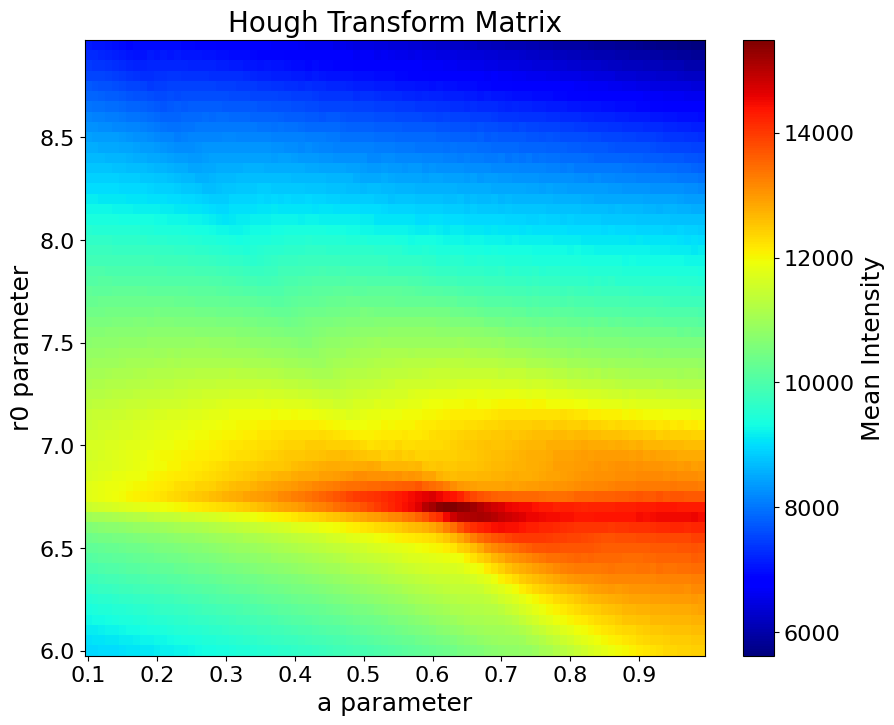

In [25]:
r0_val = np.arange(6,9,0.05)
a_val = np.arange(0.1, 1, 0.01)
hough = np.zeros((len(r0_val),len(a_val)))
r0_hough = np.zeros(z_int.shape[0])
a_hough = np.zeros(z_int.shape[0])

for i in range(z_int.shape[0]): #z_int.shape[0]
    # Reset the hough array for each image
    hough = np.zeros((len(r0_val),len(a_val)))
    
    for r0_idx, r0 in enumerate(r0_val):
        for a_idx, a in enumerate(a_val):
            s = shue(theta, r0, a)
            x_s, y_s = pol2cart(s,theta)
            mask = (y_s>y[0]) & (y_s<y[-1])
            x_shue = x_s[mask]
            y_shue = y_s[mask]

            y_ind = ((y_shue - y[0]) / (y[-1] - y[0]) * (y.shape[0] - 1))
            x_ind = ((x_shue - x[0]) / (x[-1] - x[0]) * (x.shape[0] - 1))
            y_ind = np.clip(y_ind.round().astype(int), 0, y.shape[0] - 1)
            x_ind = np.clip(x_ind.round().astype(int), 0, x.shape[0] - 1)

            # Use advanced indexing to get the mean intensity at the specified coordinates
            hough[r0_idx, a_idx] = np.mean(z_int[i][x_ind, y_ind])
    
            # Find the maximum for this image and store the optimal parameters
            max_idx = np.unravel_index(np.argmax(hough), hough.shape)
            max_r0_idx, max_a_idx = max_idx
            
            r0_hough[i] = r0_val[max_r0_idx]
            a_hough[i] = a_val[max_a_idx]
            
# Plot the final hough transform (from the last image)
plt.figure(figsize=(10, 8))
plt.pcolormesh(a_val, r0_val, hough, shading='nearest', cmap='jet')
plt.colorbar(label='Mean Intensity')
plt.xlabel('a parameter')
plt.ylabel('r0 parameter')
plt.title(f'Hough Transform Matrix')
plt.show()

In the Z-axis integration we find good agreement between the Hough-fitted model and the cube-extracted model. This is not surprising considering that the Shue model was constructed solely by crossings of a satellite in equatorial orbit, and therefore describes this plane accurately. This highlights the success of the method when utilizing a representative empirical model.

In [26]:

for i in range(z_int.shape[0]):
    s_optimal = shue(theta, r0_hough[i], a_hough[i])
    x_s_optimal, y_s_optimal = pol2cart(s_optimal, theta)
    mask_optimal = (y_s_optimal > y[0]) & (y_s_optimal < y[-1])

    x_shue_optimal = x_s_optimal[mask_optimal]
    y_shue_optimal = y_s_optimal[mask_optimal]

    # Plot the image with the optimal Shue boundary
    plt.figure(figsize=(12, 8))
    plt.pcolormesh(x, y, z_int[i].T, alpha=0.8, vmax=5e4, cmap='jet')
    plt.colorbar(label='Intensity')
    plt.plot( x_s_optimal[mask_optimal],y_s_optimal[mask_optimal], 'r-', linewidth=3, label=f'Hough Shue (r0={r0_hough[i]:.2f}, a={a_hough[i]:.2f})')
    # mask = (mp_XY_y_t[:,i]>y[0]) & (mp_XY_y_t[:,i]<y[-1])
    # plt.plot(mp_XY_x_t[mask,i],mp_XY_y_t[mask,i], label='Cube extracted magnetopause', linewidth=3 , color='black')

    interpolate = interp1d(mp_XY_y_t[:,i], mp_XY_x_t[:,i], kind='cubic', fill_value="extrapolate")
    x_interp = interpolate(y)
    plt.plot(x_interp,y, label='Cube extracted magnetopause', linewidth=3 , color='black')

    # plt.scatter(r0_cube[i],0, label='r0 from cube', color = 'black', s = 20)
    plt.xlabel('X [RE]')
    plt.ylabel('Y [RE]')
    plt.title('Integration over Z-axis')
    plt.xlim(0,20)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f'Results/dlatep/plot_{i:03d}.png')
    plt.close()

/var/folders/l4/212nnx6x7816r9kh3wjl9f7w0000gn/T/ipykernel_60196/1593296299.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'Results/dlatep/plot_{i:03d}.png')


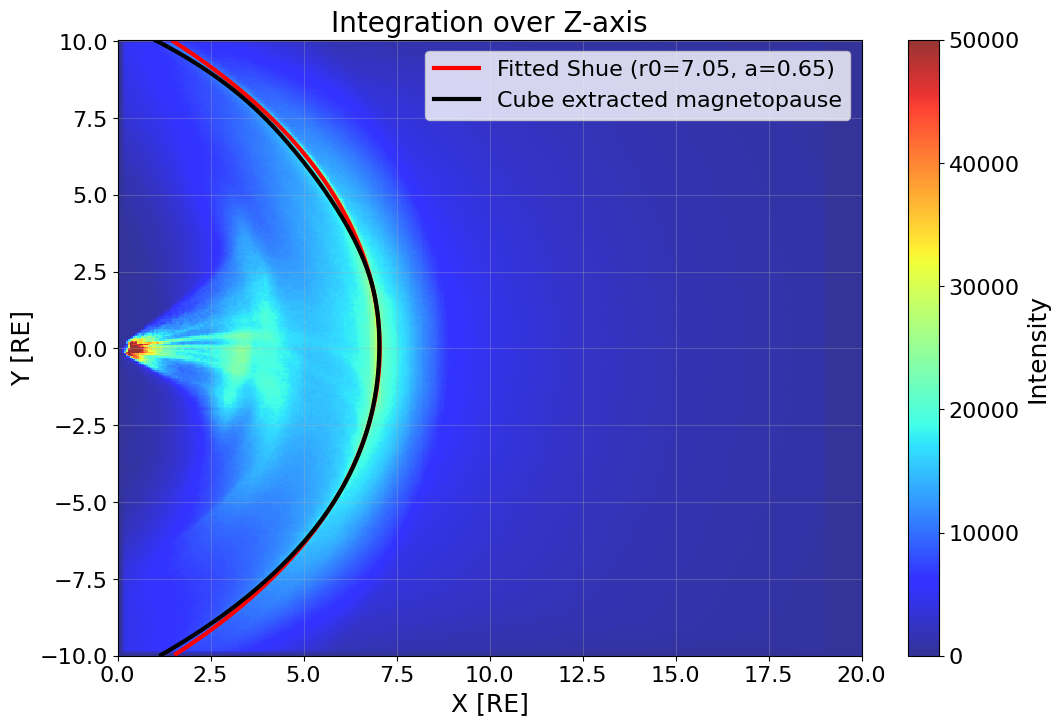

In [27]:
i = 0 
s_optimal = shue(theta, r0_hough[i], a_hough[i])
x_s_optimal, y_s_optimal = pol2cart(s_optimal, theta)
mask_optimal = (y_s_optimal > y[0]) & (y_s_optimal < y[-1])

x_shue_optimal = x_s_optimal[mask_optimal]
y_shue_optimal = y_s_optimal[mask_optimal]

# Plot the image with the optimal Shue boundary
plt.figure(figsize=(12, 8))
plt.pcolormesh(x, y, z_int[i].T, alpha=0.8, vmax=5e4, cmap='jet')
plt.colorbar(label='Intensity')
plt.plot( x_s_optimal[mask_optimal],y_s_optimal[mask_optimal], 'r-', linewidth=3, label=f'Fitted Shue (r0={r0_hough[i]:.2f}, a={a_hough[i]:.2f})')
# mask = (mp_XY_y_t[:,i]>y[0]) & (mp_XY_y_t[:,i]<y[-1])

interpolate = interp1d(mp_XY_y_t[:,i], mp_XY_x_t[:,i], kind='cubic', fill_value="extrapolate")
x_interp = interpolate(y)
plt.plot(x_interp,y, label='Cube extracted magnetopause', linewidth=3 , color='black')

# plt.scatter(r0_cube[i],0, label='r0 from cube', color = 'black', s = 20)
plt.xlabel('X [RE]')
plt.ylabel('Y [RE]')
plt.title('Integration over Z-axis')
plt.xlim(0,20)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

However, when moving to the Y-axis POV, the Shue model fails to capture the complexity of the magnetopause surface, as it can not describe the indentation of the cusps or any asymmetry. This leads to the flaring parameter capturing sometimes the inner cusp boundary and other times the outer magnetopause  depending on the solar wind conditions. Other empirical models, although including a description of the cusps, do not predict such a prominent indentation. In order to extract the maximum information from such viewing angles, new models shall be constructed and parametrized. 


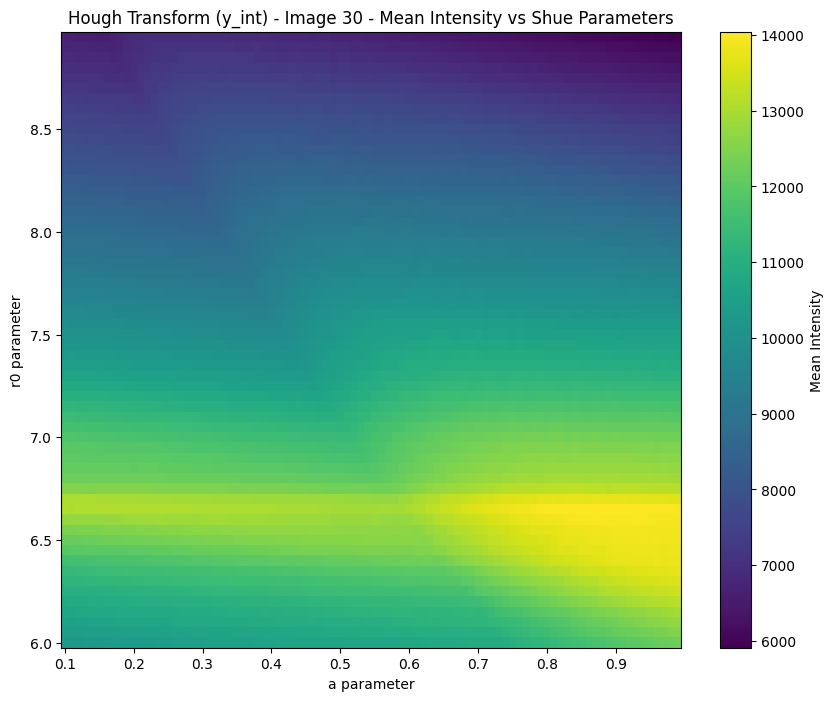

In [14]:
r0_hough_y = np.zeros(y_int.shape[0])
a_hough_y = np.zeros(y_int.shape[0])

for i in range(y_int.shape[0]):
    hough_y = np.zeros((len(r0_val), len(a_val)))
    for r0_idx, r0 in enumerate(r0_val):
        for a_idx, a in enumerate(a_val):
            s = shue(theta, r0, a)
            x_s, y_s = pol2cart(s, theta)
            mask = (y_s > z[0]) & (y_s < z[-1])
            x_shue = x_s[mask]
            y_shue = y_s[mask]

            y_ind = ((y_shue - y[0]) / (y[-1] - y[0]) * (y.shape[0] - 1))
            x_ind = ((x_shue - x[0]) / (x[-1] - x[0]) * (x.shape[0] - 1))
            y_ind = np.clip(y_ind.round().astype(int), 0, y.shape[0] - 1)
            x_ind = np.clip(x_ind.round().astype(int), 0, x.shape[0] - 1)

            hough_y[r0_idx, a_idx] = np.mean(y_int[i][x_ind, y_ind])

    max_idx = np.unravel_index(np.argmax(hough_y), hough_y.shape)
    max_r0_idx, max_a_idx = max_idx
    r0_hough_y[i] = r0_val[max_r0_idx]
    a_hough_y[i] = a_val[max_a_idx]

plt.figure(figsize=(10, 8))
plt.pcolormesh(a_val, r0_val, hough_y, shading='nearest')
plt.colorbar(label='Mean Intensity')
plt.xlabel('a parameter')
plt.ylabel('r0 parameter')
plt.title(f'Hough Transform (y_int) - Image {y_int.shape[0]-1} - Mean Intensity vs Shue Parameters')
plt.show()

In [15]:

for i in range(y_int.shape[0]): 
   # Generate the Shue boundary with the optimal parameters
    s_optimal = shue(theta, r0_hough_y[i], a_hough_y[i])
    x_s_optimal, y_s_optimal = pol2cart(s_optimal, theta)
    mask_optimal = (y_s_optimal > y[0]) & (y_s_optimal < y[-1])

    x_shue_optimal = x_s_optimal[mask_optimal]
    y_shue_optimal = y_s_optimal[mask_optimal]

    # Plot the image with the optimal Shue boundary
    plt.figure(figsize=(12, 8))
    plt.pcolormesh(x, y, y_int[i].T, alpha=0.8, vmax=5e4, cmap = 'jet')
    plt.colorbar(label='Intensity')
    plt.plot( x_s_optimal[mask_optimal],y_s_optimal[mask_optimal], 'r-', linewidth=3, label=f'Hough Shue (r0={r0_hough[i]:.2f}, a={a_hough[i]:.2f})')

    mask = (mp_XZ_z_t[:,i]>-5) & (mp_XZ_z_t[:,i]<5)
   #  plt.plot(mp_XZ_x_t[mask,i],mp_XZ_z_t[mask,i], label='Cube magnetopause', linewidth=3 , color='black')

   #  interpolate = interp1d(mp_XY_y_t[:,i], mp_XY_x_t[:,i], kind='cubic', fill_value="extrapolate")
   #  x_interp = interpolate(y)
   #  plt.plot(x_interp,y[mask], label='Cube extracted magnetopause', linewidth=3 , color='black')

    plt.scatter(r0_cube[i],0, label='Extracted r0 from cube', color = 'black', s = 20)
    plt.xlabel('X [RE]')
    plt.ylabel('Z [RE]')
    plt.xlim(0,20)
    plt.title('Integration over the Y-axis')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f'Results/dlatep_y/plot_{i:03d}.png')
    plt.close()

/var/folders/l4/212nnx6x7816r9kh3wjl9f7w0000gn/T/ipykernel_60196/1306932684.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'Results/dlatep_y/plot_{i:03d}.png')


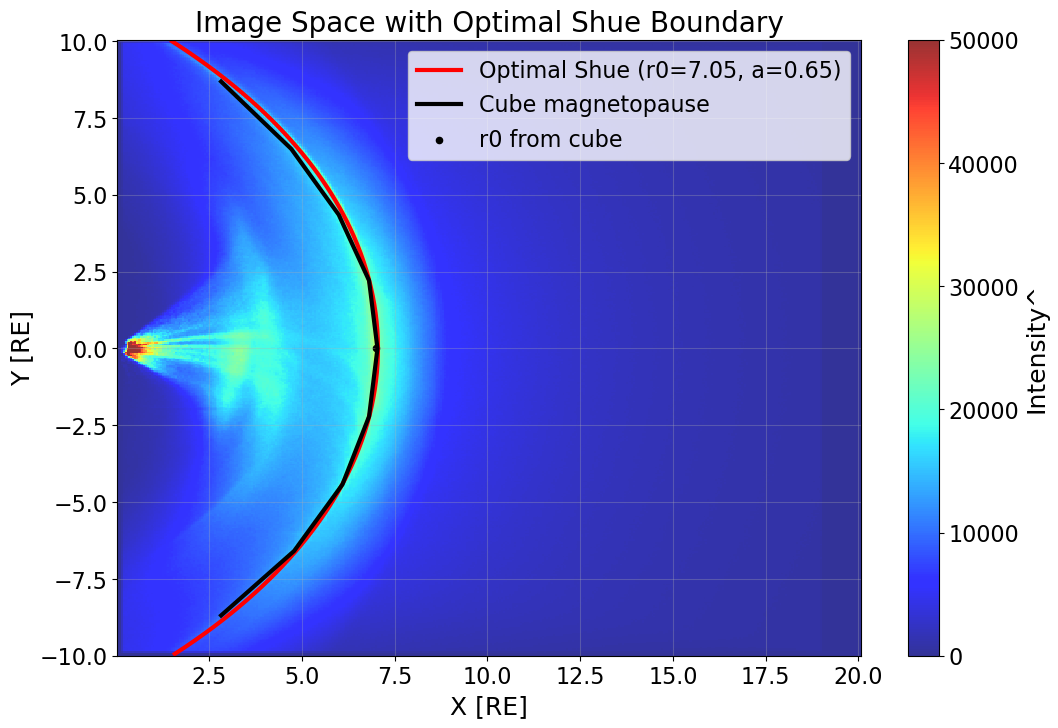

In [54]:
i=0

s_optimal = shue(theta, r0_hough[i], a_hough[i])
x_s_optimal, y_s_optimal = pol2cart(s_optimal, theta)
mask_optimal = (y_s_optimal > y[0]) & (y_s_optimal < y[-1])

x_shue_optimal = x_s_optimal[mask_optimal]
y_shue_optimal = y_s_optimal[mask_optimal]

# Plot the image with the optimal Shue boundary
plt.figure(figsize=(12, 8))
plt.pcolormesh(x, y, z_int[i].T, alpha=0.8, vmax=5e4, cmap='jet')
plt.colorbar(label='Intensity^')
plt.plot( x_s_optimal[mask_optimal],y_s_optimal[mask_optimal], 'r-', linewidth=3, label=f'Optimal Shue (r0={r0_hough[i]:.2f}, a={a_hough[i]:.2f})')
mask = (mp_XY_y_t[:,i]>y[0]) & (mp_XY_y_t[:,i]<y[-1])
plt.plot(mp_XY_x_t[mask,i],mp_XY_y_t[mask,i], label='Cube magnetopause', linewidth=3 , color='black')

plt.scatter(r0_cube[i],0, label='r0 from cube', color = 'black', s = 20)
plt.xlabel('X [RE]')
plt.ylabel('Y [RE]')
plt.title('Image Space with Optimal Shue Boundary')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

Taking these limitations into account, we can still extract usefull information about the subsolar distance - one of the main objectives of the mission. The time evolution of the estimated $r_0$ for each case as well as the relative error to the cube-extracted subsolar point is shown below.

Text(0, 0.5, '$r_0[RE]$')

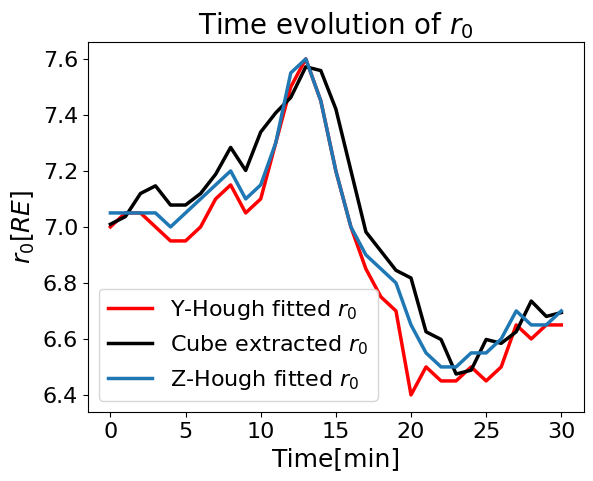

In [ ]:
plt.plot(r0_hough_y, color='red', label='Y-Hough fitted $r_0$')
plt.plot(r0_cube, label='Cube extracted $r_0$', color='black')
plt.plot(r0_hough, label='Z-Hough fitted $r_0$')
plt.legend()
plt.title('Time evolution of $r_0$')
plt.xlabel('Time[min]')
plt.ylabel('$r_0[RE]$')

Text(0, 0.5, '$r_0$ Error [RE]')

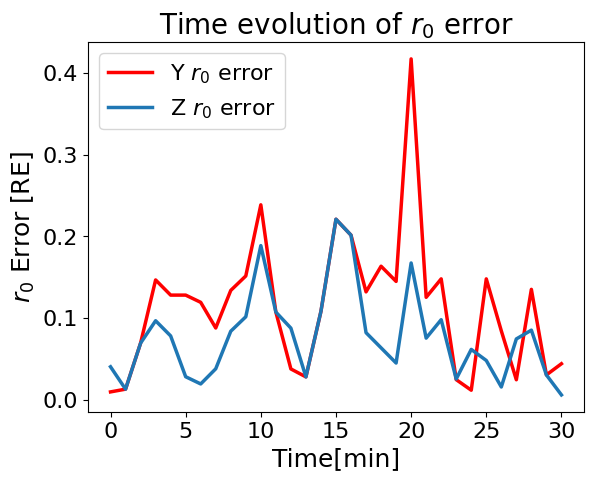

In [43]:

plt.plot(np.abs(r0_hough_y-r0_cube),label='Y $r_0$ error', color='red')
plt.plot(np.abs(r0_hough-r0_cube),label='Z $r_0$ error')
plt.legend()
plt.title('Time evolution of $r_0$ error')
plt.xlabel('Time[min]')
plt.ylabel('$r_0$ Error [RE]')

In [44]:
print(np.mean(np.abs(r0_hough-r0_cube)))
print(np.mean(np.abs(r0_hough_y-r0_cube)))

0.07710960661976349
0.11502500110624575
